# Examples

RlassoModels includes four estimators `Rlasso`, `RlassoLogit`, `RlassoPDS` and `RlassoIV`. The dataset from Acemoglu, Johnson and Robinson (2001) will be used as a running example, to highlight the different models. This is dataset is also used for various examples in the stata packages [lassopack](https://statalasso.github.io/docs/lassopack/help/rlasso_help/) and [pdslasso](https://statalasso.github.io/docs/pdslasso/ivlasso_help/) by Ahrens, Hansen & Schaffer (2018, 2020) on which RlassoModels is largely based. See also the R version [HDM](https://arxiv.org/abs/1603.01700) (Chernozkukov, Hansen & Spindler, 2016). 

In [1]:
# imports
from rlassomodels import Rlasso, RlassoPDS, RlassoIV
from sklearn.linear_model import LassoCV, LassoLarsIC, LassoLarsCV
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.testing import assert_equal

In [2]:
# get data and select y and X
ajr_df = pd.read_stata("https://statalasso.github.io/dta/AJR.dta")
X = ajr_df[["lat_abst", "edes1975", "avelf", 'temp1', 'temp2', 'temp3', 'temp4', 'temp5', 'humid1',
            "humid2", 'humid3', 'humid4' ,"oilres","steplow", "deslow", "stepmid","desmid", "drystep", 
            "drywint", "landlock", "goldm", "iron", "silv", "zinc"]]

y = ajr_df["logpgp95"]
print(f"Dimensions: {ajr_df.shape}")
ajr_df.head()

Dimensions: (64, 36)


,shortnam,logpgp95,avexpr,lat_abst,logem4,edes1975,avelf,temp1,temp2,temp3,...,zinc,oilres,baseco,_merge,indtime,euro1900,democ1,cons1,democ00a,cons00a
0,AGO,7.770645,5.363636,0.136667,5.634789,0.0,0.772755,26.0,28.0,37.0,...,0.0,146000.0,1.0,matched (3),20.0,8.000000,0.0,3.0,0.0,1.0
1,ARG,9.133459,6.386364,0.377778,4.232656,90.0,0.176932,17.0,25.0,40.0,...,0.0,46900.0,1.0,matched (3),170.0,60.000004,1.0,1.0,3.0,3.0
2,AUS,9.897972,9.318182,0.300000,2.145931,99.0,0.112797,17.0,18.0,43.0,...,12.0,99100.0,1.0,matched (3),94.0,98.000000,10.0,7.0,10.0,7.0
3,BFA,6.845880,4.454545,0.144444,5.634789,0.0,0.546718,29.0,38.0,48.0,...,0.0,0.0,1.0,matched (3),35.0,0.000000,0.0,3.0,0.0,1.0
4,BGD,6.877296,5.136364,0.266667,4.268438,0.0,0.000000,25.0,29.0,42.0,...,0.0,0.0,1.0,matched (3),23.0,0.000000,8.0,7.0,0.0,1.0


### Rlasso

The class `Rlasso` is a [scikit-learn](https://scikit-learn.org/stable/) compatible estimator that implements the lasso and square-root lasso with data-driven and theoretically justified penalty level (see: Belloni et al.,2011, 2013). It adopts the syntax where all hyperparameters are definied upon class instantiation and data, or data-dependent arguments, is passed to the `fit()` method. This for example means that it can be passed to a [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). In adition, it is also possible to call `fit_formula()` which uses R-style model specification, made possible by the package [patsy](https://patsy.readthedocs.io/en/latest/).

In [3]:
# define model and fit
rlasso = Rlasso(post=True, sqrt=False, cov_type="robust")
res1 = rlasso.fit(X,y)
# fit same model but using formula
formula = "logpgp95 ~ " + " + ".join(X.columns)
res2 = rlasso.fit_formula(formula, data=ajr_df)

assert_equal(res1.coef_, res2.coef_)

We can compare the results of different `Rlasso` specifications to common alternatives for choosing $\lambda$, featured in `sklearn`.

In [4]:
# define models
models = {
          "rlasso": Rlasso(post=False),  # post-lasso is default
          "sqrt-rlasso": Rlasso(sqrt=True, post=False),
          "rlasso-post": Rlasso(),
          "AIC": LassoLarsIC(criterion="aic", normalize=False),
          "BIC": LassoLarsIC(criterion="bic", normalize=False),
          "CV": LassoLarsCV(cv=5,normalize=False)
          }
          
results = {}
for name, model in models.items():
    tmp_res = model.fit(X,y)
    results[name] = np.array([tmp_res.intercept_] + tmp_res.coef_.tolist())
    
pd.DataFrame(results, index=["intercept"] + X.columns.tolist()).round(3)

,rlasso,sqrt-rlasso,rlasso-post,AIC,BIC,CV
intercept,7.981,7.952,8.141,7.039,7.039,7.580
lat_abst,0.000,0.000,0.000,0.000,0.000,0.000
edes1975,0.011,0.009,0.018,0.021,0.021,0.015
avelf,-0.270,-0.137,-1.004,0.000,0.000,-0.450
temp1,0.000,0.000,0.000,0.000,0.000,0.165
temp2,0.000,0.000,0.000,0.000,0.000,-0.027
temp3,0.000,0.000,0.000,0.000,0.000,-0.062
temp4,0.000,0.000,0.000,0.000,0.000,-0.075
temp5,0.000,0.000,0.000,0.000,0.000,-0.007
humid1,0.000,0.000,0.000,0.000,0.000,0.002


As can be seen, rlasso tends to produce sparse solutions compared to cross-validation and in this example, selecting other variables than both AIC and BIC. To get an insight into the performance of Rlasso, estimates can be compared to the oracle estimator of running OLS only on active components. As can be seen from the example below, post-rlasso, that is running OLS on the rlasso selected components, significantly outperforms all other models and achives near oracle performance. Looking at the second plot, it is easy to see that this must be the case since rlasso almost always selects all the correct components.

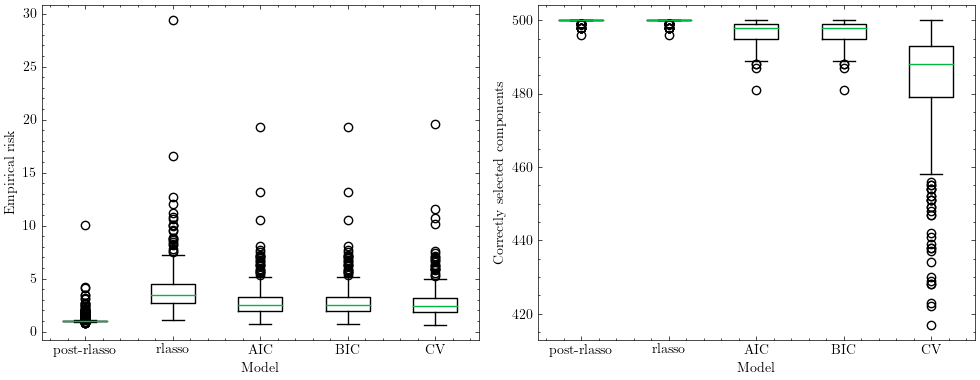

In [5]:
def sparse_dgf():
    """
    Data-generating function following Belloni (2011).
    Taken from statsmodels tests:
    https://github.com/statsmodels/statsmodels/blob/c1e30d9534dbe56346e50517da4dacf023a4aad7
    /statsmodels/regression/tests/test_regression.py#L1311
    """
    # Based on the example in the Belloni paper
    n = 100
    p = 500
    ii = np.arange(p)
    cx = 0.5 ** np.abs(np.subtract.outer(ii, ii))
    cxr = np.linalg.cholesky(cx)

    X = np.dot(np.random.normal(size=(n, p)), cxr.T)
    b = np.zeros(p)
    b[:5] = [1, 1, 1, 1, 1]
    y = np.dot(X, b) + 0.5 * np.random.normal(size=n)

    return X, y, b, cx



oracle_ratio = defaultdict(list)
correct_selected = defaultdict(list)

n_sims = 500
models = {
          "rlasso":Rlasso(post=False),
          "post-rlasso":Rlasso(),
          "AIC": LassoLarsIC(normalize=False,noise_variance=0.5),# needs sigma when p>n
          "BIC": LassoLarsIC(normalize=False,noise_variance=0.5),# needs sigma when p>n
          "CV": LassoLarsCV(cv=5,normalize=False)
          }

def oracle_sim():
    for _ in range(n_sims):
        X,y,b,cx = sparse_dgf()
        # oracle estimator (OLS) on true support
        X_oracle = X[:,:5]
        oracle_est = np.zeros(X.shape[1])
        oracle_est[:5] = np.linalg.solve(X_oracle.T@X_oracle, X_oracle.T@y)

        oracle_e = np.zeros(X.shape[1])
        oracle_e = oracle_est - b

        oracle_selected = oracle_est != 0
        denom = np.sqrt(np.dot(oracle_e, np.dot(cx, oracle_e)))

        for name, model in models.items():


            # get estimate
            est = model.fit(X, y)
            e = est.coef_ - b
            selected = est.coef_ != 0
            numer = np.sqrt(np.dot(e, np.dot(cx, e)))

            # get ratio
            oracle_ratio[name].append(numer / denom)
            # correctly selected components
            correct_selected[name].append((oracle_selected == selected).sum())

    # plot results from simulations
    # oracle ratio
    with plt.style.context("science"):
        fig, axs = plt.subplots(ncols=2, dpi=100, figsize=(10,4))
        axs[0].boxplot([oracle_ratio["post-rlasso"], oracle_ratio["rlasso"], 
                        oracle_ratio["AIC"], oracle_ratio["BIC"],
                        oracle_ratio["CV"]])

        axs[0].set_ylabel("Empirical risk")
        axs[0].set_xlabel("Model")
        axs[0].set_xticks([1,2,3,4,5],["post-rlasso", "rlasso", "AIC", "BIC", "CV"])

        # correctly selected components
        axs[1].boxplot([correct_selected["post-rlasso"], correct_selected["rlasso"], 
                        correct_selected["AIC"], correct_selected["BIC"], 
                        correct_selected["CV"]])
        axs[1].set_ylabel("Correctly selected components")
        axs[1].set_xlabel("Model")
        axs[1].set_xticks([1,2,3,4,5],["post-rlasso", "rlasso", "AIC", "BIC", "CV"])

        plt.tight_layout()
        plt.show()
    
oracle_sim()

### RlassoPDS

`RlassoPDS` extends `Rlasso` to be used for causal inference in the following setting

$$
y_{i}=\alpha d_{i}+x_{i}^{\prime} \beta+\varepsilon_{i}
$$

Where $d_{i}$ is a scalar exogenous variable (can also be low-dimensional vector) for which we are interested in a obtaining a consistent estimate with valid standard errors and test statistics in the presence of high-dimensional $x_i$. This is possible using the *post-double-selection* (PDS) and *post-regularization* (CHS) methodology developed in a series of papers by Belloni et al. (2011, 2013, 2014) and Chernozhukov et al. (2015). By default both methods are used. Since the purpose is inference and we're interested in a limited amount of variables, the class is purposly no longer directly scikit-learn compatible. Instead, it uses the econometrics package [linearmodels](https://bashtage.github.io/linearmodels/) in the final estimation stage to produce relevant outputs. This is shown below by considering a case where we want to perform inference for the variable `avexpr`:

In [6]:
d_exog = ajr_df["avexpr"]
rlasso_pds = RlassoPDS().fit(X,y,D_exog=d_exog)

print(rlasso_pds.summary())
print(f"Std. Errors and Test statistics valid for\n{rlasso_pds.valid_vars_}")

              Model Comparison              
                            PDS          CHS
--------------------------------------------
Dep. Variable          logpgp95     logpgp95
Estimator                   OLS          OLS
No. Observations             64           64
Cov. Est.            unadjusted   unadjusted
R-squared                0.7261       0.4199
Adj. R-squared           0.7075       0.4107
F-statistic              169.67       46.318
P-value (F-stat)         0.0000    1.005e-11
================== ============ ============
const                 5.7641***             
                       (0.3774)             
avexpr                0.3913***    0.3913***
                       (0.0562)     (0.0575)
edes1975              0.0091***             
                       (0.0032)             
zinc                    -0.0079             
                       (0.0281)             
avelf                -0.9975***             
                       (0.2474)             
----------

### RlassoIV

`RlassoIV` is used when one wants to use instruments in order to estimate low-dimensional endogenous variables in the setting

$$
\begin{aligned}
&y_{i}=\alpha d_{i}+x_{i}^{\prime} \beta+\varepsilon_{i} \\
&d_{i}=x_{i}^{\prime} \gamma+z_{i}^{\prime} \delta+u_{i}
\end{aligned}
$$

where both $z_i$ and $x_i$ are possibily high-dimensional. Note that we can still include exogonous variables. In the example below, we now treat `avexpr` as endogenous and specify that rigorous lasso should be used both to select instruments and controls.

In [7]:
# get data and select y and X
ajr_df = pd.read_stata("https://statalasso.github.io/dta/AJR.dta")

# some instruments have NaN values
ajr_df.dropna(inplace=True)

X = ajr_df[["edes1975", 'temp1', 'temp2', 'temp3', 'temp4', 'temp5', 'humid1',
            "humid2", 'humid3', 'humid4' ,"oilres","steplow", "deslow", "stepmid","desmid", "drystep", 
            "drywint", "landlock", "goldm", "iron", "silv", "zinc", "lat_abst", "avelf"]]

y = ajr_df["logpgp95"]
# subset instruments and endogenous var
Z = ajr_df[["logem4", "euro1900", "democ1", "cons1","democ00a", "cons00a"]]
d_endog = ajr_df["avexpr"]

In [8]:
rlasso_iv = RlassoIV(select_X=True, select_Z=True)

rlasso_iv.fit(X, y, D_exog=None, D_endog=d_endog, Z=Z)

summary = rlasso_iv.summary()

In [9]:
print(summary)

                 Model Comparison                 
                                PDS            CHS
--------------------------------------------------
Dep. Variable              logpgp95       logpgp95
Estimator                   IV-2SLS        IV-2SLS
No. Observations                 59             59
Cov. Est.                unadjusted     unadjusted
R-squared                    0.4334        -0.5831
Adj. R-squared               0.3915        -0.6104
F-statistic                  66.517         7.3846
P-value (F-stat)          1.232e-13         0.0066
==================     ============   ============
const                       3.1400*               
                           (1.6429)               
edes1975                     0.0025               
                           (0.0070)               
zinc                        -0.0658               
                           (0.0523)               
avelf                     -0.7468**               
                           (0.3

## References

Acemoglu, D., Johnson, S., & Robinson, J. A. (2001). The colonial origins of comparative development: An empirical investigation. American economic review, 91(5), 1369-1401.

Ahrens, A., Hansen, C. B., & Schaffer, M. (2020). LASSOPACK: Stata module for lasso, square-root lasso, elastic net, ridge, adaptive lasso estimation and cross-validation.

Ahrens, A., Hansen, C.B., Schaffer, M.E. 2018. pdslasso and ivlasso: Programs for post-selection and post-regularization OLS or IV estimation and inference. http://ideas.repec.org/c/boc/bocode/s458459.html

Chernozhukov, V., Hansen, C., & Spindler, M. (2016). hdm: High-dimensional metrics. arXiv preprint arXiv:1608.00354.

Chernozhukov, V., Hansen, C., & Spindler, M. (2015). Post-selection and post-regularization inference in linear models with many controls and instruments. American Economic Review, 105(5), 486-90.

Belloni, A., Chen, D., Chernozhukov, V. and Hansen, C. (2012). Sparse models and methods for optimal instruments with an application to eminent domain. Econometrica 80 (6), 2369-2429.

Belloni, A., Chernozhukov, V. and Hansen C., (2013). Inference for high-dimensional sparse econometric models. In Advances in Economics and Econometrics: 10th World Congress, Vol. 3: Econometrics, Cambridge University Press: Cambridge, 245-295.

Belloni, A., Chernozhukov, V., Hansen, C. (2014). Inference on treatment effects after selection among high-dimensional controls. The Review of Economic Studies 81(2), 608-650..